In [1]:
import torch
import torch.nn as nn

import torchvision.datasets
import torchvision.transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
config = {'batch_size' : 16, 'latent_dim' : 10, 'learning_rate' : 0.00001, 'epoch' : 30}

In [3]:
# 학습 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MNIST datasets을 다운로드
train_data = torchvision.datasets.MNIST('./input', train=True, download=True, transform=torchvision.transforms.ToTensor())

# DataLoader에 데이터셋 탑재
train_dataloader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:06<00:00, 1.43MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 163kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:02<00:00, 719kB/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.36MB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [17]:
class Encoder(nn.Module):
    def __init__(self, x_dim = 784, h1_dim = 196, h2_dim = 49, z_dim = config['latent_dim']):
        super(Encoder, self).__init__()

        # 1st hidden layer: 784 --> 196
        self.fc1 = nn.Sequential(
            nn.Linear(x_dim, h1_dim),
            nn.ReLU()
        )

        # 2nd hidden layer: 196 --> 49
        self.fc2 = nn.Sequential(
            nn.Linear(h1_dim, h2_dim),
            nn.ReLU()
        )

        # output layer: 49 --> 10
        self.mu = nn.Linear(h2_dim, z_dim)
        self.logvar = nn.Linear(h2_dim, z_dim)


    # Reparameterization Trick을 위한 함수 (샘플링 과정에서 미분 가능성을 유지하기 위함)
    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # std와 동일한 shape로 0~1 사이의 실수로 난수 생성
        return mu + eps * std  # 최종적으로 z를 출력
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)

        mu = self.mu(x)
        logvar = self.logvar(x)

        z = self.reparameterization(mu, logvar)
        
        return z, mu, logvar
    

class Decoder(nn.Module):
    def __init__(self, x_dim = 784, h1_dim = 196, h2_dim = 49, z_dim = config['latent_dim']):
        super(Decoder, self).__init__()

        # 1st hidden layer: 10 --> 49
        self.fc1 = nn.Sequential(
            nn.Linear(z_dim, h2_dim),
            nn.ReLU()
        )

        # 2nd hidden layer: 49 --> 196
        self.fc2 = nn.Sequential(
            nn.Linear(h2_dim, h1_dim),
            nn.ReLU()
        )

        # output layer: 196 --> 784
        self.fc3 = nn.Linear(h1_dim, x_dim)

    def forward(self, z):
        z = self.fc1(z)
        z = self.fc2(z)
        z = self.fc3(z)
        pred = nn.Sigmoid()(z)

        return pred


In [18]:
# Encoder, Decoder를 생성하고 device에 올리기
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 모델 파라미터, Learning rate를 기반으로 Optimizer 정의
parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr = config['learning_rate'])


In [19]:
for epoch in tqdm(range(config['epoch'])):
    for i, (x, _) in enumerate(train_dataloader):
        input = x.view(config['batch_size'], -1).to(device)
        z, mu, logvar = encoder(input)
        output = decoder(z)

        # Reconstruction loss, Regularization loss 계산
        reconst_loss = nn.BCELoss(reduction = 'sum')(output, input)
        regular_loss = 0.5 * torch.sum(mu**2 + torch.exp(logvar) - logvar - 1)

        # Backward
        loss = reconst_loss + regular_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f' Loss: {loss}')

  3%|▎         | 1/30 [00:31<15:03, 31.15s/it]

 Loss: 3570.44091796875


  7%|▋         | 2/30 [01:01<14:15, 30.54s/it]

 Loss: 3443.936767578125


 10%|█         | 3/30 [01:31<13:41, 30.41s/it]

 Loss: 3164.834716796875


 13%|█▎        | 4/30 [02:04<13:35, 31.37s/it]

 Loss: 3057.34326171875


 17%|█▋        | 5/30 [02:35<13:06, 31.44s/it]

 Loss: 3089.692626953125


 20%|██        | 6/30 [03:11<13:11, 32.98s/it]

 Loss: 3383.739013671875


 23%|██▎       | 7/30 [03:44<12:39, 33.01s/it]

 Loss: 2879.084228515625


 27%|██▋       | 8/30 [04:20<12:26, 33.93s/it]

 Loss: 3028.69775390625


 30%|███       | 9/30 [04:59<12:22, 35.37s/it]

 Loss: 2940.08544921875


 33%|███▎      | 10/30 [05:39<12:13, 36.69s/it]

 Loss: 2795.01220703125


 37%|███▋      | 11/30 [06:18<11:52, 37.51s/it]

 Loss: 2621.859130859375


 40%|████      | 12/30 [06:53<11:04, 36.90s/it]

 Loss: 2777.265625


 43%|████▎     | 13/30 [07:25<09:59, 35.28s/it]

 Loss: 2438.554443359375


 47%|████▋     | 14/30 [07:58<09:12, 34.51s/it]

 Loss: 2389.435546875


 50%|█████     | 15/30 [08:32<08:38, 34.55s/it]

 Loss: 2792.472412109375


 53%|█████▎    | 16/30 [09:01<07:36, 32.64s/it]

 Loss: 2741.78271484375


 57%|█████▋    | 17/30 [09:31<06:54, 31.85s/it]

 Loss: 2238.861572265625


 60%|██████    | 18/30 [10:02<06:19, 31.61s/it]

 Loss: 2426.81884765625


 63%|██████▎   | 19/30 [10:39<06:06, 33.30s/it]

 Loss: 2623.754150390625


 67%|██████▋   | 20/30 [11:10<05:25, 32.59s/it]

 Loss: 2704.72705078125


 70%|███████   | 21/30 [11:43<04:56, 32.91s/it]

 Loss: 2540.04541015625


 73%|███████▎  | 22/30 [12:11<04:11, 31.44s/it]

 Loss: 2534.00244140625


 77%|███████▋  | 23/30 [12:39<03:32, 30.34s/it]

 Loss: 2408.74853515625


 80%|████████  | 24/30 [13:10<03:03, 30.58s/it]

 Loss: 2479.221435546875


 83%|████████▎ | 25/30 [13:41<02:32, 30.47s/it]

 Loss: 2326.68115234375


 87%|████████▋ | 26/30 [14:11<02:02, 30.58s/it]

 Loss: 2309.29150390625


 90%|█████████ | 27/30 [14:53<01:41, 33.91s/it]

 Loss: 2466.991455078125


 93%|█████████▎| 28/30 [15:33<01:11, 35.56s/it]

 Loss: 2118.533935546875


 97%|█████████▋| 29/30 [16:11<00:36, 36.37s/it]

 Loss: 2203.857666015625


100%|██████████| 30/30 [16:48<00:00, 33.61s/it]

 Loss: 2223.920654296875


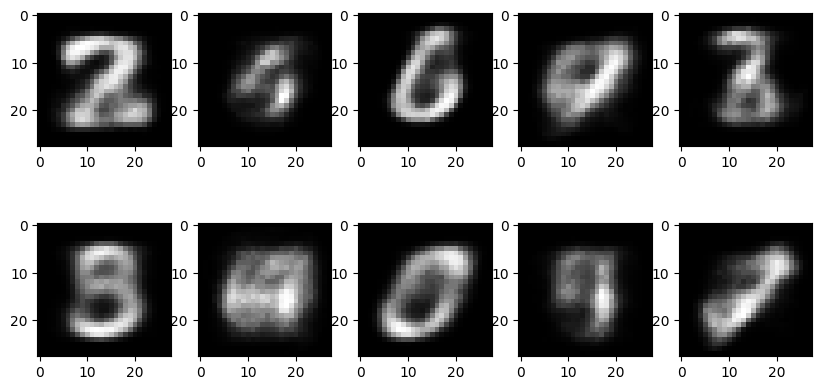

In [20]:
# N(0, 1)에서 반복추출하여 latent vector z를 Sampling

check_num_image = 10 # Inference 하고자 하는 이미지 수
z = torch.randn(check_num_image, config['latent_dim']).to(device)
sampled_images = decoder(z).view(check_num_image, 28, 28)

# Inference 결과 시각화 
fig = plt.figure(figsize = (10, check_num_image//2)) # figure 크기: (10, 5)

for idx, img in enumerate(sampled_images):
    ax = fig.add_subplot(2, check_num_image//2, idx + 1) # 2행 5열 
    img = img.detach().numpy()
    ax.imshow(img, cmap = 'gray')
